1. Import necessary libraries and PORT-EK source code:

In [26]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps
from scipy.stats import pearsonr
from datetime import datetime
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2812559


2. Declare data set specific definitions and functions:

In [27]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.19  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.5  # This is the RMSE threshold used to select enriched k-mers
mm = 42 # This is the maximum number of allowed mismatches when mapping k-mers to rerference genome

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/subB"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["Bmain", "Bout"]

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]

AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "Bmain_enriched": ("#ffa401", 1),
    "Bout_enriched": ("#005ff5", 1),
}

HIV_GENES = {
    "5' LTR": (1, 634),
    "gag": (790, 2292),
    "pol": (2358, 5096),
    "vif": (5041, 5619),
    "vpr": (5559, 5795),
    "tat_1ex": (5831, 6045),
    "tat_2ex": (8379, 8653),
    "rev_1ex": (5970, 6045),
    "rev_2ex": (8379, 8653),
    "env": (6225, 8795),
    "nef": (8797, 9168),
    "3' LTR": (9086, 9719),
}

ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    # match_score=5,
    # mismatch_score=-4,
    # open_gap_score=-10,
    # extend_gap_score=-0.5,
    scoring="megablast",
    mode="local"
)


def assign_gene_from_interval(ref_pos: list, gene_dict: dict) -> str:
    genes = []
    for start, end in ref_pos:
        for gene, gene_range in gene_dict.items():
            if (
                len(
                    [
                        pos
                        for pos in range(start, end + 1)
                        if pos in list(range(gene_range[0], gene_range[1] + 1))
                    ]
                )
                > 0
            ):
                genes.append(gene)

    return ", ".join(genes)

def assign_gene_from_position(ref_pos: int, gene_dict: dict) -> str:
    genes = []
    for gene, gene_range in gene_dict.items():
        if gene_range[0] < ref_pos < gene_range[1]:
            genes.append(gene)
    return ", ".join(genes)

3. Construct k-mer count matrix and apply rarity filter

In [28]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.

# kmer_set = set()
# kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
# for filename in kmer_set_in_path:
#     with open(filename, mode="rb") as in_file:
#         partial_set = pickle.load(in_file)
#     kmer_set.update(partial_set)

kmer_set = set(pd.read_csv("../output/HIV/scenario4/enriched_11mer_stat_matrix.csv", index_col=0).index)
kmer_set = set(portek.encode_kmer(kmer) for kmer in kmer_set)
sample_list = []
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")
for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
group_sample_idx = {group:[] for group in SAMPLE_GROUPS}
for sample in sample_list:
    group_sample_idx[sample.split("_")[0]].append(sample)

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")




Imported 6348 kmers and 11276 samples.


In [29]:
# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"{counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: portek.decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if "AAAAAAAAAAA" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop("AAAAAAAAAAA")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

11276 of 11276 indices done.
3714 common k-mers remaining after filtering at a threshold of 0.19.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [30]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["seq"] = common_kmer_matrix.index
ERR_COLS = []
P_COLS = []
for j in range(1, len(SAMPLE_GROUPS)):
    for i in range(j):
        err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
        p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
        ERR_COLS.append(err_name)
        P_COLS.append(p_name)
        common_kmer_matrix[err_name] = (
            common_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
            - common_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
        )
        common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                group_sample_idx[SAMPLE_GROUPS[i]],
                group_sample_idx[SAMPLE_GROUPS[j]],
                common_kmer_matrix,
            ),
        )
        common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))


common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(
    portek.assign_kmer_group, p_cols = P_COLS, avg_cols = AVG_COLS,axis=1
)
common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)


/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [31]:
common_kmer_matrix.to_csv(f"../output/HIV/subB/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/HIV/subB/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/HIV/subB/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/HIV/subB/common_{k}mer_count_matrix.csv", index_col=0)
# common_kmer_stat_matrix  = pd.read_csv(f"../output/HIV/subB/common_{k}mer_stat_matrix.csv", index_col=0)
# all_kmer_matrix= pd.read_csv(f"../output/HIV/subB/all_{k}mer_count_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

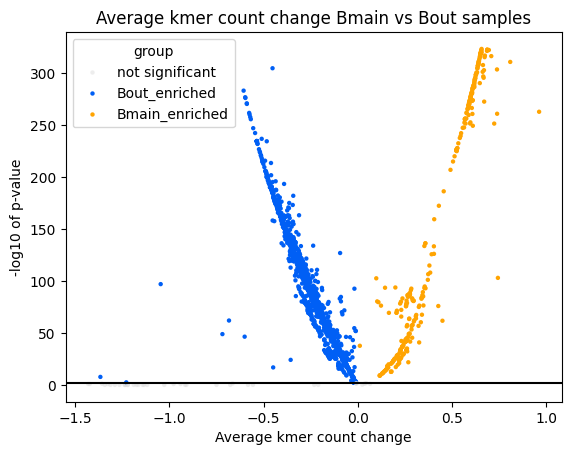

In [32]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.autoscale()
ax.set_title('Average kmer count change Bmain vs Bout samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='Bmain-Bout_err', y = '-log10_Bmain-Bout_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.savefig("../output/HIV/subB/volcano.svg", dpi = 600, format = "svg")

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [33]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

enriched_kmer_matrix = common_kmer_matrix[(common_kmer_matrix["group"] != "not significant") &(common_kmer_matrix["RMSE"]>min_RMSE)]
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmers = {group:list(enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"]==f"{group}_enriched"].index) for group in SAMPLE_GROUPS}
for group,kmers in enriched_kmers.items():
    print(f"{len(kmers)} {group}-enriched kmers found.")


def assign_host_numerical(sample_id):
    if sample_id in group_sample_idx["Bout"]:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix.T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

# counts_for_classifier.to_csv(f"../output/HIV/subB/{k}mer_counts_for_classifier.csv")
enriched_kmer_matrix.to_csv(f"../output/HIV/subB/enriched_{k}mer_count_matrix.csv")
enriched_kmer_stat_matrix.to_csv(f"../output/HIV/subB/enriched_{k}mer_stat_matrix.csv")

715 Bmain-enriched kmers found.
81 Bout-enriched kmers found.


8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [34]:
mutations = {}
n_pos = []
ref_pos = []
matches = []

for kmer in enriched_kmer_matrix.index:
    
    alns = aligner.align(ref_seq, kmer)
    temp_n = 0
    temp_m = []
    temp_ref_pos = []

    for aln in alns:
            aln_length = len(aln.indices[1])
            adj_score = aln.score + ((k-aln_length)*-2)

            if adj_score>=k-3*mm:
                temp_n += 1
                temp_m.append(aln.counts()[1])
                temp_ref_pos.append((aln.indices[0][0]+1,aln.indices[0][-1]+1))
                if aln_length>=k:
                    for i in range(aln_length):
                        ref_nuc = aln[0][i]
                        kmer_nuc = aln[1][i]
                        if ref_nuc == "-":
                            mut_pos = aln.indices[0][i-1]+1
                        else:
                            mut_pos = aln.indices[0][i]+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
                else:
                    for i in range(k):
                        mut_pos_0 = aln.indices[0][0]-aln.indices[1][0]+i
                        try:
                            ref_nuc = ref_seq[mut_pos_0]
                        except:
                            continue
                        kmer_nuc = kmer[i]
                        mut_pos = mut_pos_0+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
    n_pos.append(temp_n)
    matches.append(temp_m)
    ref_pos.append(temp_ref_pos)

enriched_kmer_matrix["n_pos"] = n_pos
enriched_kmer_matrix["ref_pos"] = ref_pos
enriched_kmer_matrix["matches"] = matches
enriched_kmer_matrix["genes"] = enriched_kmer_matrix["ref_pos"].apply(assign_gene_from_interval, args=[HIV_GENES])
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmer_stat_matrix.to_csv(f"../output/HIV/subB/aligned_enriched_{k}mer_stat_matrix.csv")

mutations = {mut:kmers for mut, kmers in mutations.items() if len(kmers) > k//2 and len(set(kmers.values())) == 1}

In [35]:
mutations_id = list(mutations.keys())
mutations_ref_nuc = [mutid[0] for mutid in mutations_id]
mutations_mut_nuc = [mutid[-1] for mutid in mutations_id]
mutations_ref_pos = [int(mutid[1:-1]) for mutid in mutations_id]
mutations_groups = [list(mutations[mutid].values())[0] for mutid in mutations_id]
mutations_kmres = [list(mutations[mutid].keys()) for mutid in mutations_id]
mut_df = pd.DataFrame({"ref_nuc":mutations_ref_nuc, "ref_pos":mutations_ref_pos, "mut_nuc":mutations_mut_nuc, "group":mutations_groups,"kmers":mutations_kmres}, index=mutations_id).sort_values("ref_pos")
for group in SAMPLE_GROUPS:
    mut_df[f"{group}_agg_freq"] = mut_df["kmers"].apply(portek.calc_agg_freq, args=(group_sample_idx[group], enriched_kmer_matrix))
mut_df["genes"] = mut_df["ref_pos"].apply(lambda pos: assign_gene_from_position(pos, HIV_GENES))
mut_df.to_csv(f"../output/HIV/subB/enriched_mutations.csv")

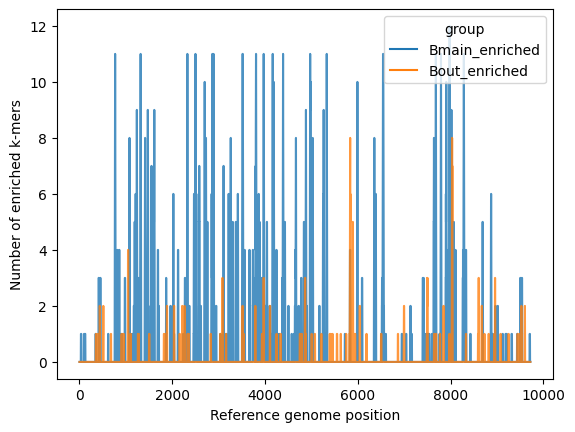

In [36]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["Bmain_enriched", "Bout_enriched"])

for kmer in enriched_kmer_matrix.index:
    group = enriched_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/HIV/subB/enriched_{k}mer_coverage.svg", format="svg", dpi=600)

(0.0, 100.0)

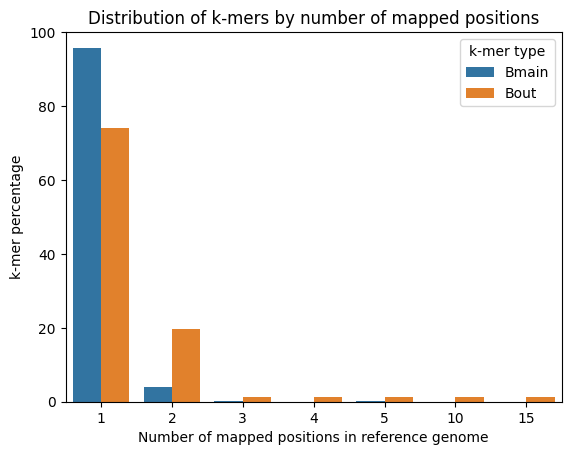

In [37]:
Bmain_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "Bmain_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["Bmain_enriched"]*100
Bout_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "Bout_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["Bout_enriched"]*100
dist = pd.concat([Bmain_dist, Bout_dist], axis=1, keys=["Bmain", "Bout"]).fillna(0).sort_index()
dist_longform = dist.melt(ignore_index=False, var_name="k-mer type")
fig, ax = plt.subplots()
sns.barplot(data = dist_longform, x = dist_longform.index, y="value", hue="k-mer type")
ax.set_title("Distribution of k-mers by number of mapped positions")
ax.set_ylabel("k-mer percentage")
ax.set_xlabel("Number of mapped positions in reference genome")
ax.set_ylim(0,100)


# plt.savefig(f"../output/HIV/subB/enriched_{k}mer_map_distr.svg", format="svg", dpi=600)

In [38]:
mut_df

,ref_nuc,ref_pos,mut_nuc,group,kmers,Bmain_agg_freq,Bout_agg_freq,genes
T3800C,T,3800,C,Bmain_enriched,"[TCAATACCCCT, CAATACCCCTC, GTCAATACCCC, TGTCAA...",0.903293,0.0,pol
C3866T,C,3866,T,Bmain_enriched,"[GCAGAAACTTT, GAAACTTTCTA, AGCAGAAACTT, CTTTCT...",0.798899,0.0,pol
G5836T,G,5836,T,Bout_enriched,"[AAATGGATCCA, GAAATGGATCC, AGAAATGGATC, TGGATC...",0.137136,1.0,tat_1ex
T8033C,T,8033,C,Bout_enriched,"[ACTCATCTGCA, GAAAACTCATC, AAAACTCATCT, AACTCA...",0.495397,1.0,env
